<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Resampling" data-toc-modified-id="Resampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resampling</a></span></li><li><span><a href="#Conclusion.-Data-preparation" data-toc-modified-id="Conclusion.-Data-preparation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Conclusion. Data preparation</a></span></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#Conclusion.-Data-analysis" data-toc-modified-id="Conclusion.-Data-analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conclusion. Data analysis</a></span></li></ul></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cross Validation</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Random-forest-model" data-toc-modified-id="Random-forest-model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random forest model</a></span></li><li><span><a href="#Holt-Winters-model" data-toc-modified-id="Holt-Winters-model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Holt-Winters model</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#General-conclusion" data-toc-modified-id="General-conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>General conclusion</a></span></li></ul></div>

# Forecasting taxi orders

The taxi aggregator has collected historical data on orders at airports. In order to attract more drivers during the peak period, it was necessary to predict the number of taxi orders for the next hour. It was necessary to build a model for such a prediction.   
The value of the RMSE metric on the test sample should be no more than 48.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
except:
    data = pd.read_csv('taxi.csv', parse_dates=['datetime'])

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


### Resampling

In [5]:
data = data.set_index('datetime')

In [6]:
data = data.resample('H').sum()

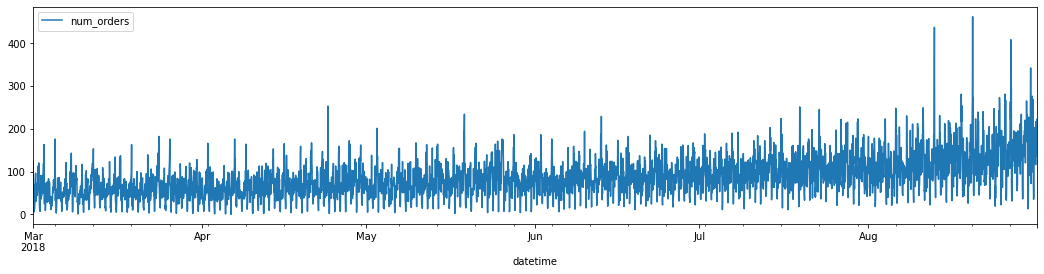

In [7]:
data.plot(figsize=(18,4));

Let's enrich the feature space. Let's add offsets and information about the day of the week, month.

In [8]:
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

In [9]:
def create_lags(data, target_col, lags_list):
    for i in lags_list:
        data['lag_' + str(i)] = data[target_col].shift(i)
    return data

In [10]:
data = create_lags(data, 'num_orders', [1, 2, 3, 6, 12, 24, 48])

Let's add a sign that will allow the model to better capture the current intraday trend. To do this, we will build a sliding curve, and select the value of the window for it with our hands:

In [11]:
data['rolling_mean5'] = data['num_orders'].shift().rolling(5).mean()
data['rolling_mean30'] = data['num_orders'].shift().rolling(30).mean()
data['rolling_mean300'] = data['num_orders'].shift().rolling(300).mean()

In [12]:
data = data.dropna()

### Conclusion. Data preparation

-  Data prepared.
- There are no passes.
- Time interval of data provided: 2018-03-01 00:00:00 to 2018-08-31 23:50:00
- Dates and times are listed in chronological order.

## Data analysis

Let's analyze the data in terms of seasonality, trends, etc. Let's look at the distribution of the target feature during the day:

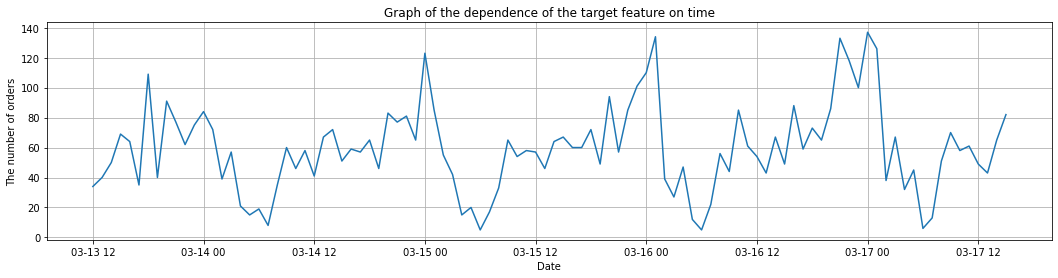

In [13]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(data['num_orders'].iloc[0:100])
ax.set_title('Graph of the dependence of the target feature on time')
ax.set_ylabel('The number of orders')
ax.set_xlabel('Date')
plt.grid(True)
plt.show()

There is a strong spread in the values of the target feature during the day. A clear seasonality within the day is visible: a peak at 00:00, a decline in the morning, and an abrupt increase by midnight.

Let's check the series for stationarity using the Dickey-Fuller test:

**Null hypothesis:** the series has a unit root (is not stationary)  
**Alternative hypothesis:** the series does not have a unit root (it is stationary)

In [14]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [15]:
adf_test(data.num_orders)

Results of Dickey-Fuller Test:
Test Statistic                   -3.016203
p-value                           0.033409
#Lags Used                       30.000000
Number of Observations Used    4085.000000
Critical Value (1%)              -3.431952
Critical Value (5%)              -2.862248
Critical Value (10%)             -2.567147
dtype: float64


In [16]:
decomposed = seasonal_decompose(data.num_orders)

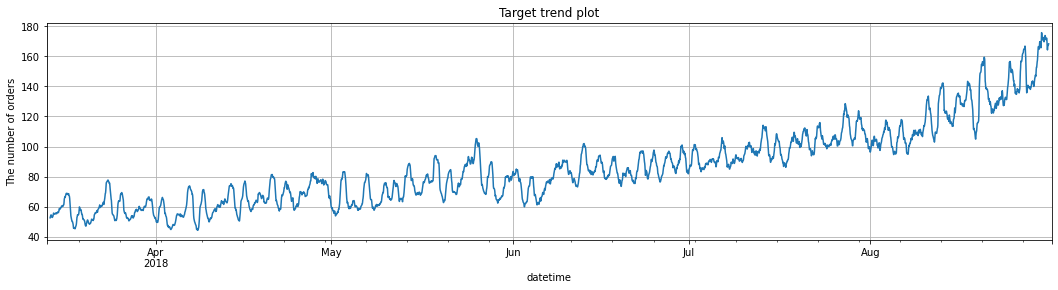

In [17]:
plt.figure(figsize=(18, 4))
decomposed.trend.plot()
plt.title('Target trend plot')
plt.ylabel('The number of orders')
plt.grid(True)

Let's look at seasonality:

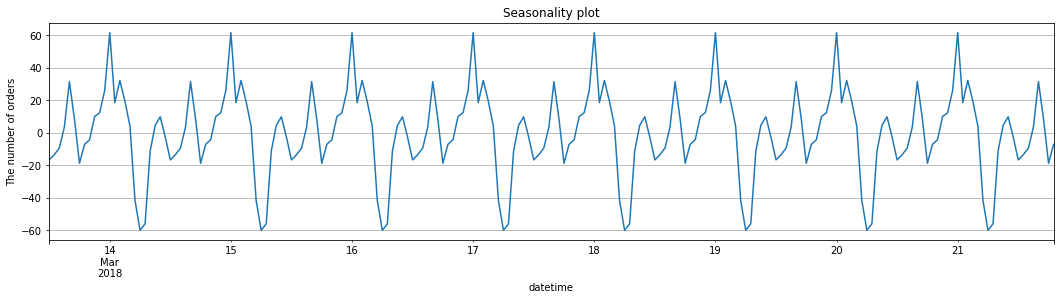

In [18]:
plt.figure(figsize=(18, 4))
decomposed.seasonal[:200].plot()
plt.title('Seasonality plot')
plt.ylabel('The number of orders')
plt.grid(True)

We have seasonality, and it is expressed within one day. Every day the picture is repeated. Seasonality is additive. This observation, together with the upward trend, and the variance increasing towards the tail of the series, allows us to consider that the series is not stationary.

### Conclusion. Data analysis
- The number of taxi orders to the airport is growing in summer. This may be due to the holiday season.  
- Clearly expressed seasonality is defined. The number of orders at 6 am is almost minimal, which cannot be said about midnight, when there is a large surge in orders.  
- The hypothesis of the stationarity of the time series was tested. The result is that the series is **not stationary.**

## Model Training

We divide our data into training and test sets. Let's make a test sample of 10% of the original data.

In [19]:
features = data.drop('num_orders', axis=1)
target = data.num_orders

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, 
                                                                            test_size=0.1, random_state=42)

print('Dimension check:')
print('Initial dataframe size:', data.shape)
print('Size of features_test:', features_test.shape)
print('Size of  features_test:', features_train.shape)
print('Size of target_train:', target_train.shape)
print('Size of target_test:', target_test.shape)

Dimension check:
Initial dataframe size: (4116, 15)
Size of features_test: (412, 14)
Size of  features_test: (3704, 14)
Size of target_train: (3704,)
Size of target_test: (412,)


### Cross Validation

First, let's write the code for cross-validation. We cannot use the standard approach to cross-validation on the time series, since the folds will be mixed and we will get a leak of the target feature from the future. Therefore, we use the following strategy:

In [22]:
def cross_validation1(features, target, model, num_folds, params=None):
    scores = []
    batch = int(np.floor(features.shape[0] / num_folds))
    for i in range(num_folds-1):
        train_features = features.iloc[0:(i+1)*batch]
        test_features = features.iloc[(i+1)*batch+1:(i+1)*batch+batch]
        
        train_target = target.iloc[0:(i+1)*batch]
        test_target = target.iloc[(i+1)*batch+1:(i+1)*batch+batch]
        
        if params != None:
            estimator = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=2))
        else:
            estimator = model 
            
        estimator.fit(train_features, train_target)
        
        if params != None:
            best_estimator = estimator.best_estimator_
        else:
            best_estimator = estimator
        
        predictions = best_estimator.predict(test_features)
        
        score = mean_squared_error(test_target, predictions)
        scores.append(score)
        

    plt.figure(figsize=(15, 5))
    plt.plot(test_target.values[0:200], label="actual")
    plt.plot(predictions[0:200], "r", label="prediction")
    
    plt.legend(loc="best")
    plt.title("Best estimator (first 200 objects) \n Train / test sample shape {} / {} \n Root mean squared error {} orders per hour".format(
            train_features.shape[0], test_features.shape[0], 
            round(np.sqrt(mean_squared_error(predictions, test_target)))))
    plt.grid(True);
    print('Average RMSE score on cross-validation:', np.sqrt(np.mean(scores)))
    
    best_estimator = estimator.fit(features, target)
        
    return best_estimator 

### Linear Regression

Average RMSE score on cross-validation: 26.65882950151272


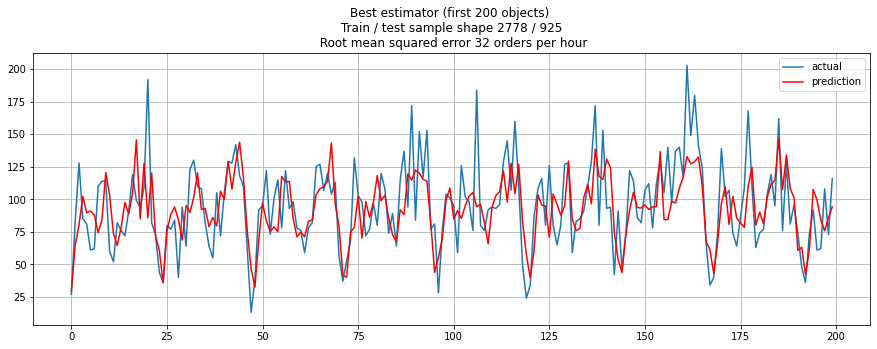

In [23]:
lr = cross_validation1(features_train, target_train, LinearRegression(), 4, None)

### Random forest model

Average RMSE score on cross-validation: 27.50623600414136


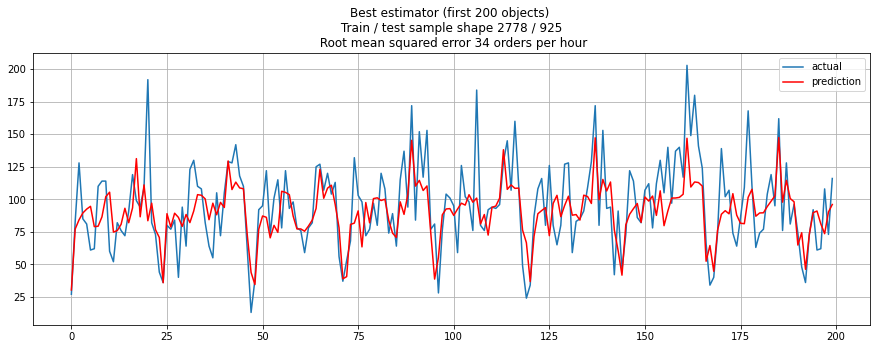

In [24]:
rf = cross_validation1(features_train, target_train, RandomForestRegressor(), 4, params={'max_depth':range(3, 6)});

### Holt-Winters model

In [25]:
def cross_validation_stat_models(target, num_folds):
    scores = []
    batch = int(np.floor(data.shape[0] / num_folds))
    for i in range(1, num_folds):
        train_target = target.iloc[0 : i*batch]
        test_target = target.iloc[i*batch : (i*batch)+batch]
        
        fit1 = ExponentialSmoothing(train_target, seasonal_periods=24, trend='add', seasonal='add'
                                ).fit()
        
        predictions = fit1.forecast(len(test_target))
        
        score = mean_squared_error(test_target, predictions)
        scores.append(score)
        
    plt.figure(figsize=(15, 5))
    plt.plot(test_target[0:500], label="actual")
    plt.plot(predictions[0:500], "r", label="prediction")

    plt.legend(loc="best")
    plt.title("Best estimator (first 500 objects) \n Train / test sample shape {} / {} \n Root mean squared error {} orders per hour".format(
    train_target.shape[0], test_target.shape[0], round(np.sqrt(np.mean(scores)))))
    plt.grid(True);
    print('Average RMSE score on cross-validation:', np.sqrt(np.mean(scores)))
    
    fit1 = ExponentialSmoothing(target, seasonal_periods=24, trend='add', seasonal='add'
                                ).fit()
        
    return fit1

Average RMSE score on cross-validation: 26.93370954265251


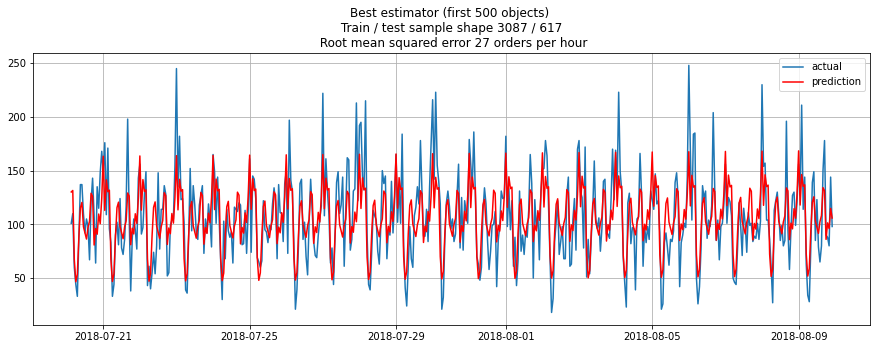

In [26]:
hw = cross_validation_stat_models(target_train, 4)

### Testing

The value of the RMSE metric on the test sample should be no more than 48.

LinearRegression RMSE test score: 44.935


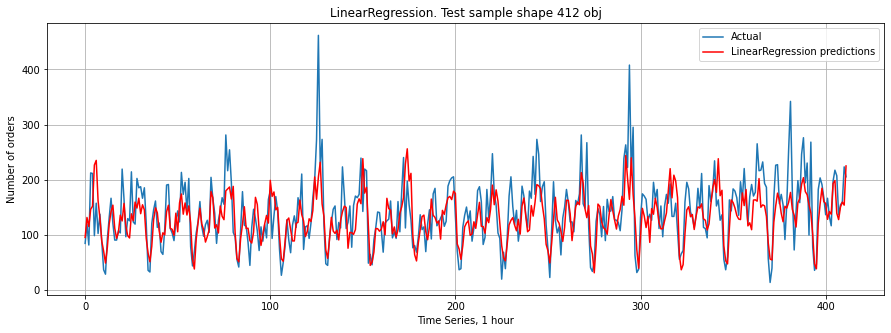

RandomForest RMSE test score: 46.590


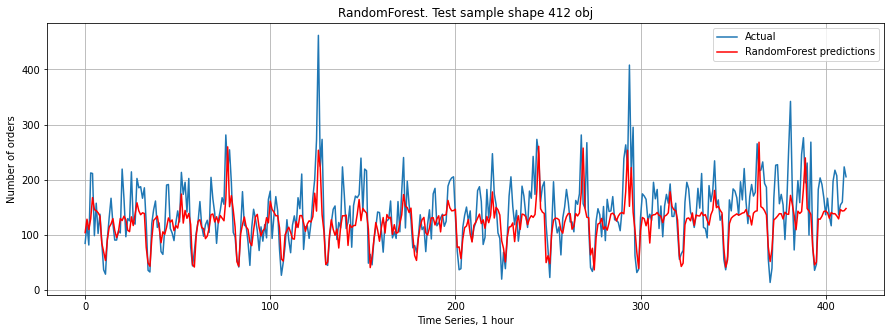

Holt-Winters RMSE test score: 43.998


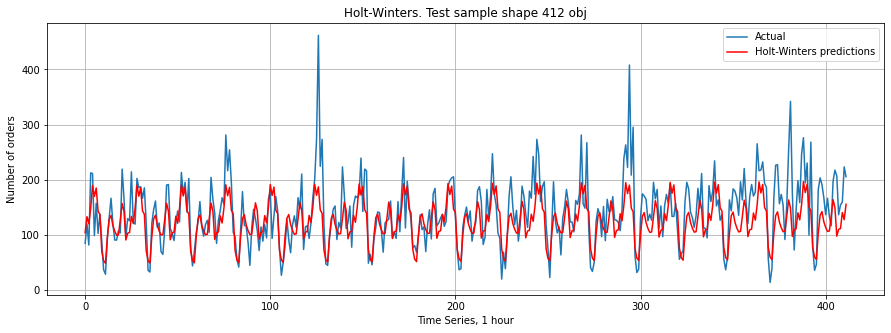

Dummy-model RMSE test score: 59.421


Text(0.5, 0, 'Time Series, 1 hour')

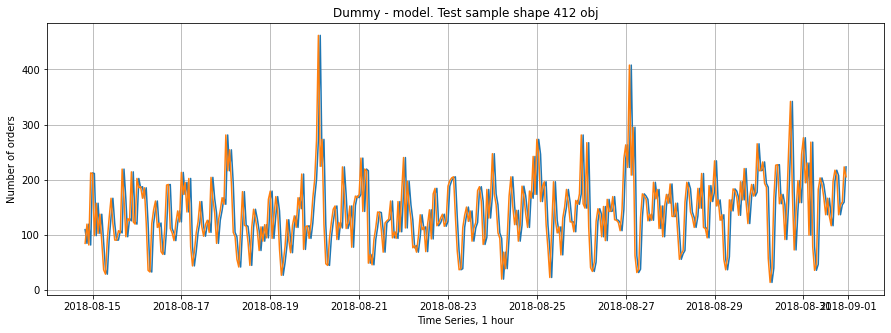

In [27]:
models = {'LinearRegression':lr, 'RandomForest':rf, 'Holt-Winters':hw}

for model_name, model in models.items():
    if model_name != 'Holt-Winters':
        predictions = model.predict(features_test)
        score = np.sqrt(mean_squared_error(target_test, predictions))
    else:
        predictions = model.forecast(len(target_test)).values
        score = np.sqrt(mean_squared_error(target_test, predictions))
    print(model_name, 'RMSE test score: %.3f' %score)
    
    plt.figure(figsize=(15, 5))
    plt.title(model_name + ". Test sample shape " + str(target_test.shape[0]) + ' obj')
    plt.plot(target_test.values, label='Actual')
    plt.plot(predictions, label=model_name+' predictions', c='r')
    plt.legend(loc="best")
    plt.grid(True)
    plt.ylabel('Number of orders')
    plt.xlabel('Time Series, 1 hour')
    plt.show()
    
dummy_predictions = features_test.lag_1
score = np.sqrt(mean_squared_error(target_test, dummy_predictions))
    
print('Dummy-model RMSE test score: %.3f' %score)
plt.figure(figsize=(15, 5))
plt.title("Dummy - model. Test sample shape " + str(target_test.shape[0]) + ' obj')
plt.plot(dummy_predictions)
plt.plot(target_test)
plt.grid(True)
plt.ylabel('Number of orders')
plt.xlabel('Time Series, 1 hour')

## General conclusion

All tested models achieved the required accuracy. The best result for the Holt-Winters model. Her RMSE = 43.998. Boosting is slightly ahead of its competitors. This is not surprising, because this model is designed specifically for working with time series. Also, all models have passed the adequacy test.